Plot the correlation between IF signal and transcriptome signal.


Using Splotch covarites files as annotation files

In [1]:
from __future__ import absolute_import, division, print_function

import os
import re
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from sklearn import preprocessing
from scipy.stats import linregress, spearmanr, pearsonr
import numpy as np
import math

import seaborn as sns

from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000

%matplotlib inline

matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial',
                           'ps.fonttype':42})

In [23]:
path = '/Users/brittalotstedt/Documents/Documents-dhcp-18-40-114-33/data/stdata/splotch/spatial_proteins/spleen/splotch'


# tags

In [24]:
# Load Lambda pmean df

# Read file
filename = os.path.join(path, 'lambdas_pmeans_output.tsv')
    
lambda_posterior_means = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1])

In [25]:
# Take exp()
lambda_posterior_means = lambda_posterior_means.astype(float)
lambda_posterior_means = np.exp(lambda_posterior_means-1)


In [26]:
# Select Nestin gene
pd.set_option('display.max_colwidth', -1)
gene = 'F480-TTAACTTCAGCCCGT'

lambda_gene = lambda_posterior_means.loc[gene, :].to_frame().reset_index()

# Get name of file, for plotting
lambda_gene['name'] = lambda_gene['file'].str.split('/').str[-1].str.split('_stdata').str[0]

print(lambda_gene.head(), lambda_gene.shape)


                                                                                                                                           file  \
0  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/tags/spleen_aug/output/Count_Tables/10015CN77_D1_stdata_adjusted.tsv   
1  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/tags/spleen_aug/output/Count_Tables/10015CN77_D1_stdata_adjusted.tsv   
2  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/tags/spleen_aug/output/Count_Tables/10015CN77_D1_stdata_adjusted.tsv   
3  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/tags/spleen_aug/output/Count_Tables/10015CN77_D1_stdata_adjusted.tsv   
4  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/tags/spleen_aug/output/Count_Tables/10015CN77_D1_stdata_adjusted.tsv   

  coordinate  F480-TTAACTTCAGCCCGT          name  
0  28_21      56.176166             10015CN77_D1  
1  9_28       5

# Ab

In [27]:
ab = 'F480'

ab_path = '/Users/brittalotstedt/Documents/Documents-dhcp-18-40-114-33/data/stdata/output/spatial_protein/total_per_spot/WOpropabilities/'

samples = list(set(lambda_gene['name'].tolist()))

ab_list = []

for well in samples:
    
    filename = os.path.join(ab_path, well + '_' + ab + '_intensitites.tsv')
    
    file = pd.read_csv(filename, sep = '\t')
    
    spot_coord = []
    
    # if spot coordinates in float...
    if len(list(file)[0].split('.')) == 3:
        for spots in list(file):
            spot_tmp = [ float(elem) for elem in spots.split('_') ]
            spot_tmp2 = [ round(elem, 0) for elem in spot_tmp ]
            spot_tmp3 = [ int(elem) for elem in spot_tmp2 ]

            new_spot_coord = str(spot_tmp3[0]) + '_' + str(spot_tmp3[1])
            spot_coord.append(new_spot_coord)
    else:
        for spots in list(file):
            spots_tmp = spots.split('_')
            new_spot_coord = str(spots_tmp[0]) + '_' + str(spots_tmp[1])   
            spot_coord.append(new_spot_coord)

    file.columns = spot_coord
    
    filemelt = pd.melt(file)
    filemelt['name'] = well
    filemelt.columns = ['coordinate', ab, 'name']
        
    ab_list.append(filemelt)

abfile = pd.concat(ab_list)
            
print(abfile.head())


  coordinate  F480          name
0  10_17      5571  10015CN77_D1
1  10_18      5905  10015CN77_D1
2  10_19      6814  10015CN77_D1
3  10_20      4690  10015CN77_D1
4  10_21      5879  10015CN77_D1


# Annotation

In [28]:
annot_list = []

for stdata in list(set(abfile['name'].tolist())):
    
    well = stdata
    
    filename = os.path.join(path, well + '_stdata_adjusted.tsv.annotations.tsv')

    annot_file = pd.read_csv(filename, sep = '\t')
    annot_file = pd.melt(annot_file, id_vars='Unnamed: 0')
    annot_file = annot_file[annot_file['value'] != 0]
    annot_file['image'] = well
    annot_file.drop(['value'], axis=1, inplace=True)
    annot_file.rename(columns = {'Unnamed: 0':'value', 'variable':'x_y'}, inplace=True)

    annot_list.append(annot_file)
    
# Concat
annotdf = pd.concat(annot_list)

print(annotdf.head())


       value    x_y         image
3   Red pulp  28_21  10015CN77_D1
7   Red pulp  9_28   10015CN77_D1
11  Red pulp  28_30  10015CN77_D1
14  PALS      3_24   10015CN77_D1
19  Red pulp  29_24  10015CN77_D1


# Merge gene + ab + annotation

In [29]:
lambdadfTMP = pd.merge(lambda_gene, abfile,  how='left', on=['name','coordinate'])
lambdadf = pd.merge(lambdadfTMP, annotdf, how='left', left_on=['name','coordinate'], right_on=['image', 'x_y'])

print(lambdadf.head())

                                                                                                                                           file  \
0  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/tags/spleen_aug/output/Count_Tables/10015CN77_D1_stdata_adjusted.tsv   
1  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/tags/spleen_aug/output/Count_Tables/10015CN77_D1_stdata_adjusted.tsv   
2  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/tags/spleen_aug/output/Count_Tables/10015CN77_D1_stdata_adjusted.tsv   
3  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/tags/spleen_aug/output/Count_Tables/10015CN77_D1_stdata_adjusted.tsv   
4  /ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/tags/spleen_aug/output/Count_Tables/10015CN77_D1_stdata_adjusted.tsv   

  coordinate  F480-TTAACTTCAGCCCGT          name   F480     value    x_y  \
0  28_21      56.176166             10015

In [34]:
# Only lok at specific regions
#lambdadf_rm = lambdadf[lambdadf['value'].isin(['Red pulp', 'B follicle', 'PALS', 'Marginal zone'])]


In [30]:
# Take mean per region per sample

#trans = lambdadf_rm.groupby(['name', 'value'])[ab, gene].mean()
trans = lambdadf.groupby(['name', 'value'])[ab, gene].mean()

trans.reset_index(inplace=True)

# Scale min max per sample
trans[[ab + '.norm', gene + '.norm']] = trans.groupby(['name'])[ab, gene].transform(lambda x: preprocessing.minmax_scale(x))

print(trans.head())

           name          value         F480  F480-TTAACTTCAGCCCGT  F480.norm  \
0  10015CN77_C1  B follicle     647.432624   52.700450             0.214668    
1  10015CN77_C1  Marginal zone  991.445652   54.268676             0.429336    
2  10015CN77_C1  PALS           303.420000   53.592022             0.000000    
3  10015CN77_C1  Red pulp       1905.955466  56.190416             1.000000    
4  10015CN77_D1  B follicle     5293.716981  52.425495             0.208907    

   F480-TTAACTTCAGCCCGT.norm  
0  0.000000                   
1  0.449353                   
2  0.255467                   
3  1.000000                   
4  0.000000                   


0.1411821024842394
Spearman's r: 0.774
Pearson's r: 0.899


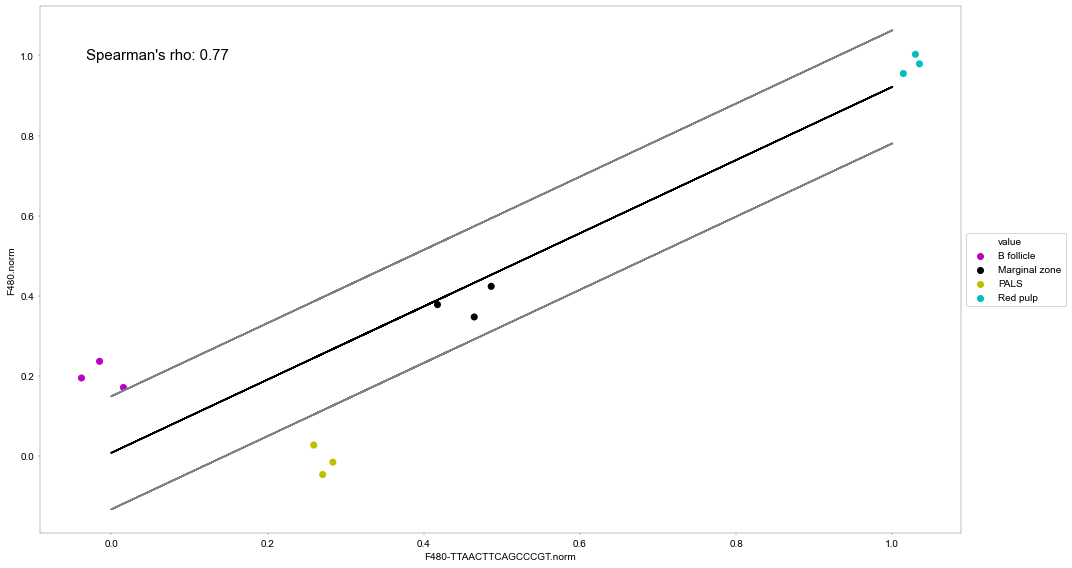

In [35]:
# Plot

# initialize a figure
fig, ax = plt.subplots(figsize=(15, 8))

plot_trans = trans.copy()

plot_trans['jitter_y'] = trans[ab + '.norm'] + 0.1 * np.random.rand(len(trans[ab + '.norm'].tolist())) -0.05
plot_trans['jitter_x'] = trans[gene + '.norm'] + 0.1 * np.random.rand(len(trans[gene + '.norm'].tolist())) -0.05

x = 'jitter_x'
y = 'jitter_y'
hue = 'value'
palette = {'Red pulp':'c', 'B follicle':'m', 'PALS':'y', 'Marginal zone':'k'}
data = plot_trans

sns.scatterplot(x=x, y=y, data=data, ax=ax, hue=hue, s=50, linewidth=0, palette=palette)

# X and Y axis
ax.set_xlabel(gene + '.norm')
ax.set_ylabel(ab + '.norm')

# Calculate the linear regression
X = gene + '.norm'
Y = ab + '.norm'

slope, intercept, r_value, p_value, std_err = linregress(data[X], data[Y])

print(std_err)

coef = np.polyfit(data[X],data[Y],1)
poly1d_fn = np.poly1d(coef)
ax.plot(data[X], poly1d_fn(data[X]), c="k")
ax.plot(data[X], poly1d_fn(data[X])+std_err, c="grey")
ax.plot(data[X], poly1d_fn(data[X])-std_err, c="grey")
#ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

# Spearman's & Pearson's r
spear, p = spearmanr(data[X], data[Y])
pear, p = pearsonr(data[X], data[Y])
print("Spearman's r: " + str(round(spear, 3)))
print("Pearson's r: " + str(round(pear, 3)))

ax.text(0.05, 0.9, "Spearman's rho: " + str(round(spear, 2)), transform=ax.transAxes, fontsize=15)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig("/Users/brittalotstedt/Documents/Documents-dhcp-18-40-114-33/data/stdata/manuscript/ST2.5/IFvsTAG_F480.pdf", transparent=True, bbox_inches = 'tight',
    pad_inches = 0, dpi=1200, rasterized=True)

# Plotting overlaps

In [10]:
def read_array_metadata(metadata,filename,n_levels, extraplot=None):
    array_metadata = metadata[metadata['Count file'] == filename]
    array_levels = [array_metadata['Level %d'%(idx+1)].values[0] for idx in range(0,n_levels)]
    
    if extraplot != None:
        array_levels = array_metadata['Extra_plot_level'].tolist()
    return array_levels

In [13]:
# Load registration file

reg_file = os.path.join(path, 'coordinate_registration_gene.p')

registered_coordinates_dict = pickle.load(open(reg_file,'rb'), encoding='bytes') 


In [15]:
# Load sample_information file

# Read file
info_file = os.path.join(path, 'information.p')

info = pickle.load(open(info_file,'rb')) 
    
metadata = info['metadata']
n_levels = info['n_levels']

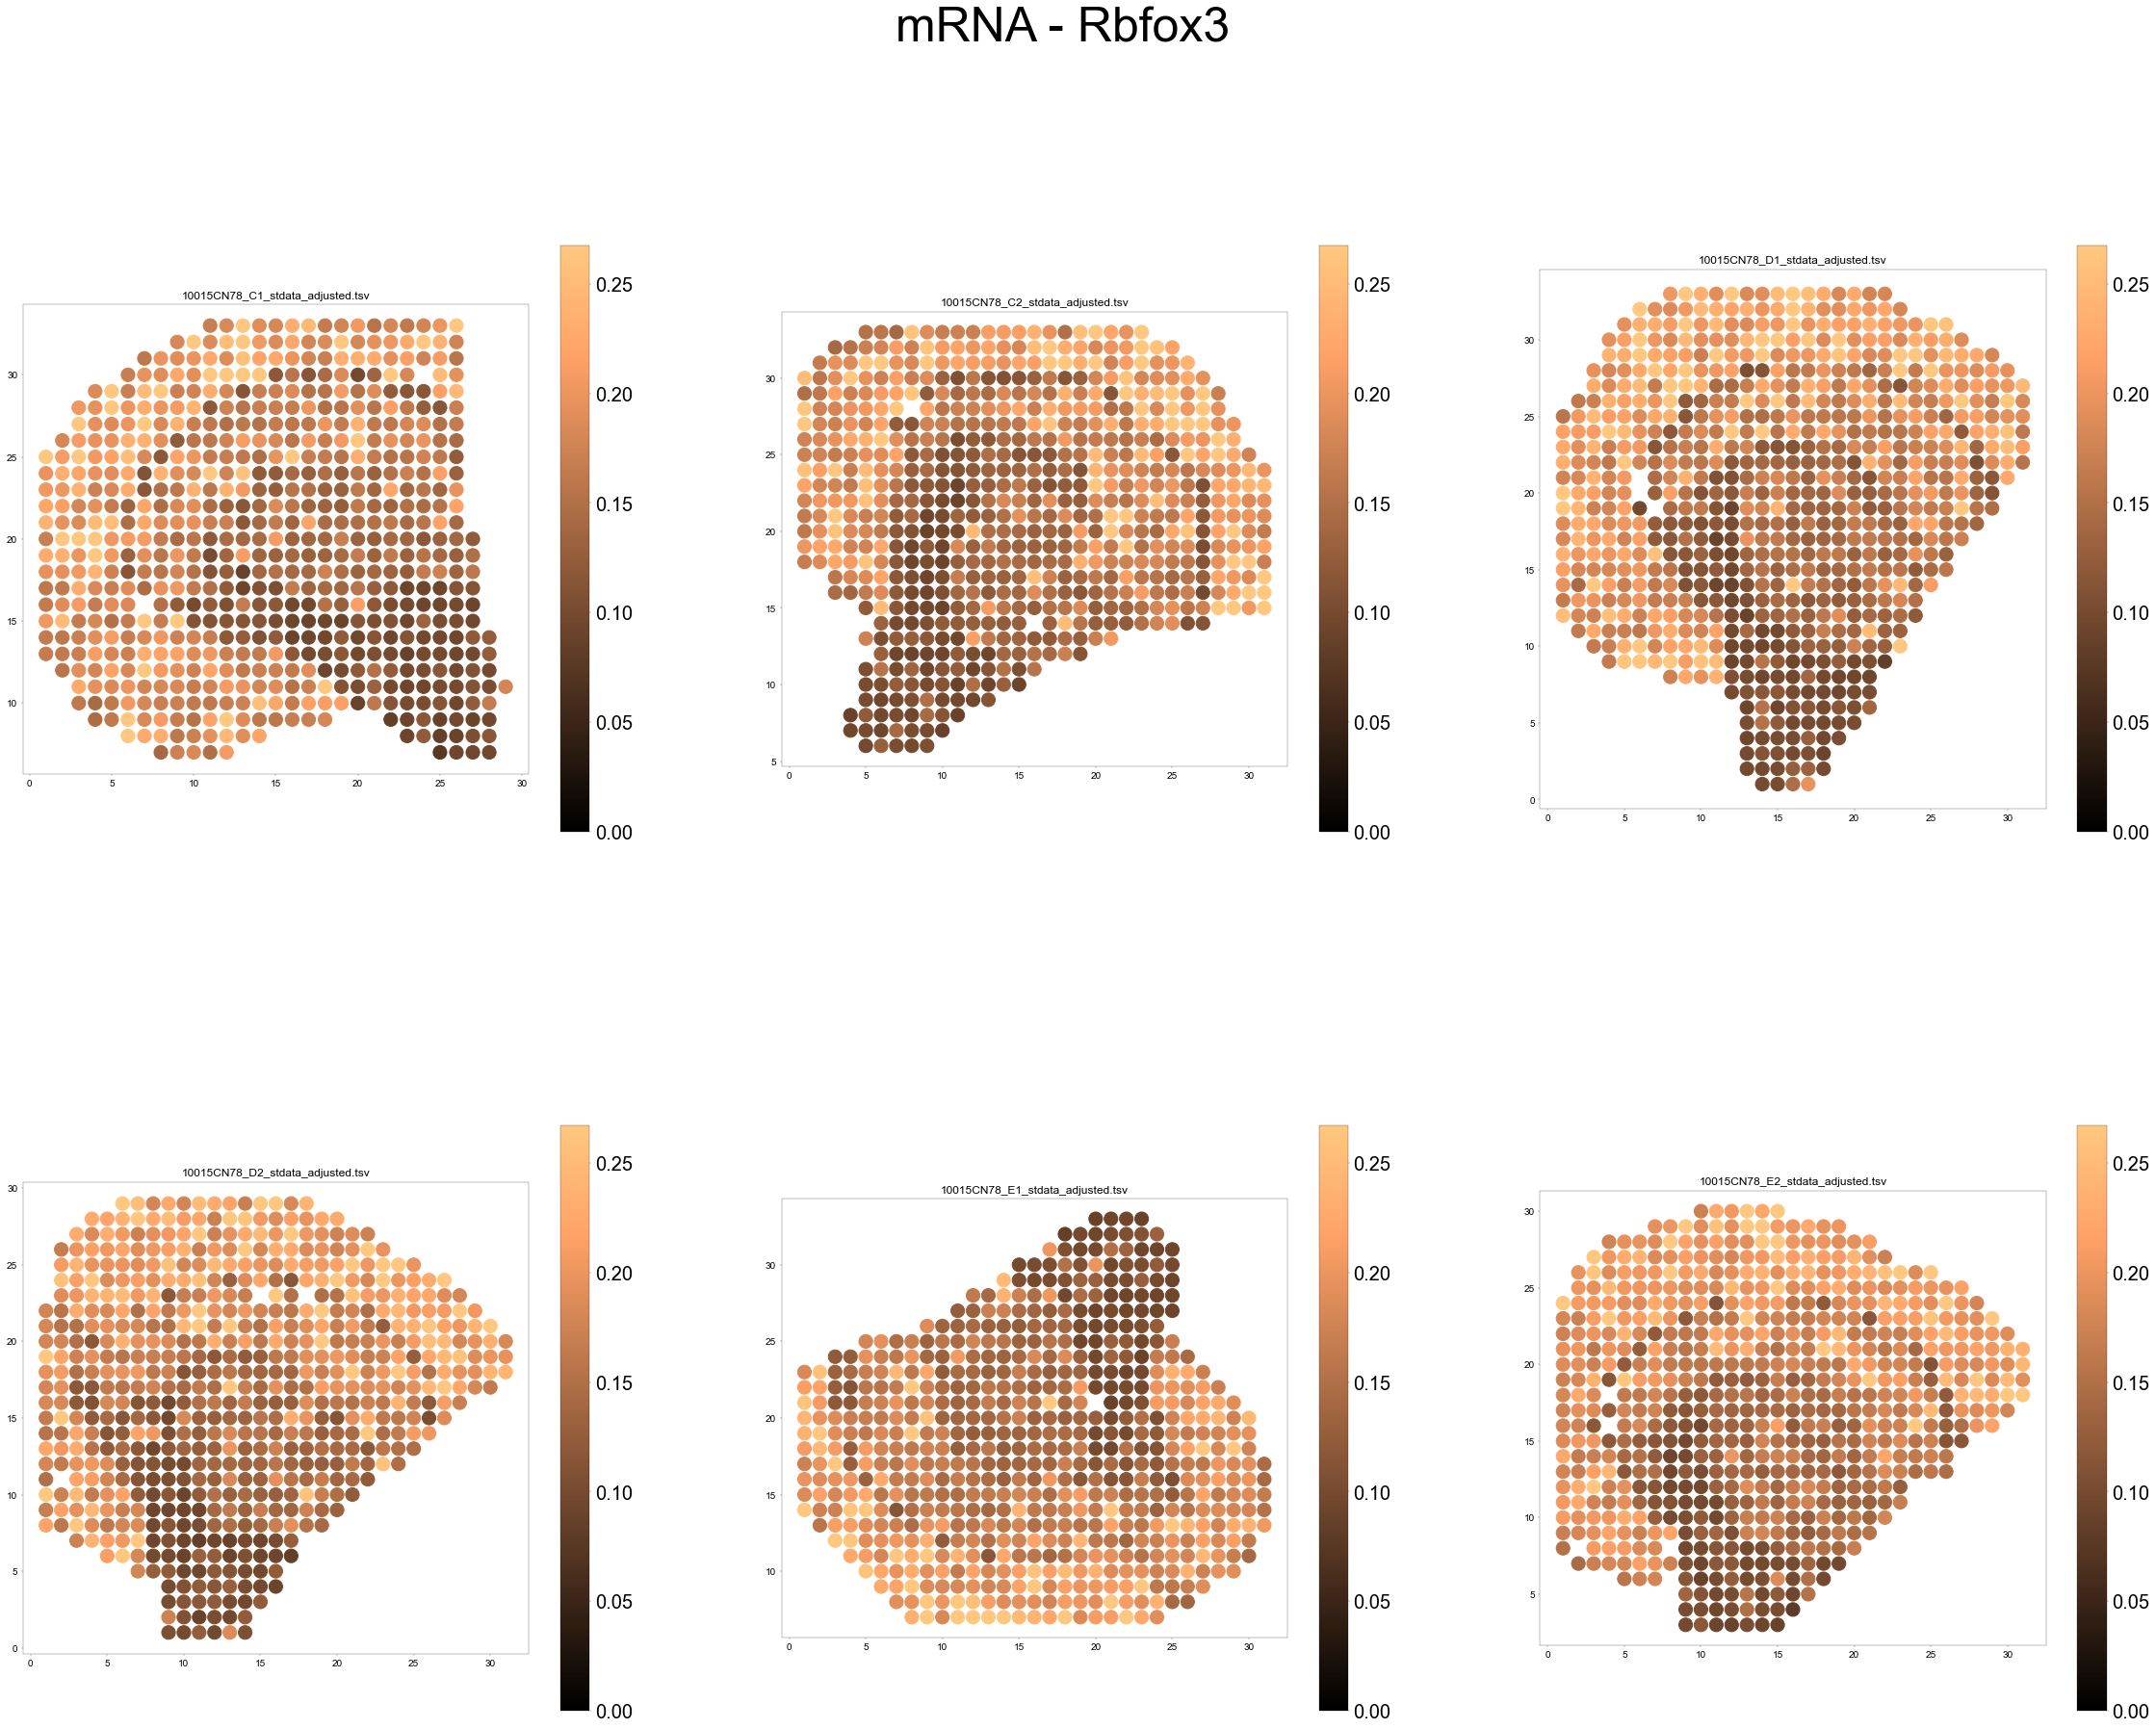

In [18]:
# initialize a figure
fig = matplotlib.pyplot.figure(figsize=(40, 30))

# get the names of the count files
count_files = np.array(list(lambda_posterior_means.columns.levels[0]))

num_cols = 3
axes = []
for i in range(0,int(len(count_files)/num_cols)):
    for j in range(0, num_cols):
        ax = plt.subplot2grid((int(len(count_files)/num_cols), num_cols), (i, j))
        axes.append(ax) 

# use the same color scale across the arrays
vmin,vmax = 0,np.percentile(lambda_posterior_means.loc[gene].values,95)

fig.suptitle('mRNA - ' + gene, fontsize=50)

# loop over the count files
for n,count_file in enumerate(count_files):
    
    ax = axes[n]

    coordinates = np.array([list(map(float,coordinate.split('_')))
                               for coordinate in list(lambda_posterior_means[count_file].columns)])

    coordinates = np.array(coordinates)
    x_coordinates = (coordinates[:,0]-1)
    y_coordinates = (coordinates[:,1]-1)
        
    
    # visualize the ST spots 
    cbmap = ax.scatter(x_coordinates,y_coordinates,
                       s=200,c=lambda_posterior_means[count_file].loc[gene],
                       cmap='copper',vmin=0,vmax=vmax,marker='o')
    
    ax.set_aspect('equal')
     
    cbar = matplotlib.pyplot.colorbar(cbmap,ax=ax,shrink=0.8)
    cbar.ax.tick_params(labelsize=20) 
    
    ax.set_title(count_file.split('/')[-1])
    
fig.subplots_adjust(top=0.90)

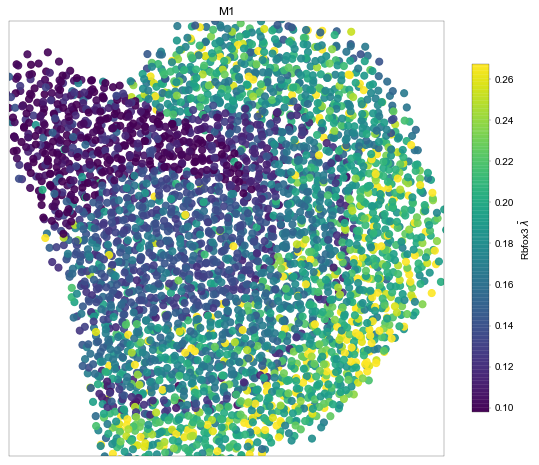

In [19]:
variables_of_interest = ['M1']
# get the names of the count files
count_files = np.array(list(lambda_posterior_means.columns.levels[0]))

# use the same color scale across the arrays
#vmin,vmax = 0,numpy.percentile(lambda_posterior_means.loc[gene].values,95)
vmin = np.percentile(lambda_posterior_means.loc[gene].values,5)
vmax = np.percentile(lambda_posterior_means.loc[gene].values,95)

# initialize a figure
fig = matplotlib.pyplot.figure()
fig.set_size_inches([len(variables_of_interest)*10,8])

# initialize axes
ax = [fig.add_subplot(1,len(variables_of_interest),ax_idx) for ax_idx in range(1,len(variables_of_interest)+1)]

# adjust the axes
for ax_idx in range(0,len(ax)):
    ax[ax_idx].set_title(variables_of_interest[ax_idx])
    
    ax[ax_idx].set_aspect('equal')
    
    ax[ax_idx].set_xticks([])
    ax[ax_idx].set_yticks([])
    
    ax[ax_idx].set_xlim([-15,15])
    ax[ax_idx].set_ylim([-15,15])

cbmap = [None for _ in range(0,len(ax))]
    
# loop over the count files
for n,count_file in enumerate(count_files):
    
    # see if the current array has the level variable of interest
    try:
        ax_idx = variables_of_interest.index(read_array_metadata(metadata,count_file,n_levels)[0])
    except ValueError:
        continue
        
    # move to the next array if the current array has not been registered 
    if count_file not in registered_coordinates_dict:
        continue
    
    # for each ST spot on the array, let us get its registered coordinate if available
    coordinates_found = np.zeros(len(list(lambda_posterior_means[count_file].columns))) # indicator of being registered
    coordinates = []  
    for coord_idx,coordinate in enumerate(list(lambda_posterior_means[count_file].columns)):
        if coordinate in registered_coordinates_dict[count_file]:
            coordinates_found[coord_idx] = 1
            coordinates.append(list(map(float,registered_coordinates_dict[count_file][coordinate].split('_'))))
    coordinates = np.array(coordinates)
    x_coordinates = coordinates[:,0]
    y_coordinates = coordinates[:,1]
    
    # visualize the registered ST spots
    cbmap[ax_idx] = ax[ax_idx].scatter(x_coordinates,y_coordinates,
                               s=50, c=lambda_posterior_means[count_file].loc[gene][coordinates_found > 0],
                               cmap='viridis',vmin=vmin,vmax=vmax,marker='o',alpha=0.9)

# add colorbars
for ax_idx in range(0,len(ax)):
    if cbmap[ax_idx] is not None:
        cbar = matplotlib.pyplot.colorbar(cbmap[ax_idx],ax=ax[ax_idx],shrink=0.8)    
        cbar.set_label(r'%s $\bar{\lambda}$'%(gene))
        
        

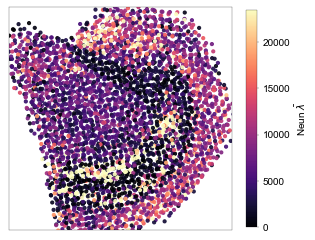

In [22]:
#Plotting overlapping ab

# Path can be found in registration coordinate file
coord_path = os.path.dirname(list(registered_coordinates_dict)[0])

variables_of_interest = ['M1']

# use the same color scale across the arrays
vmin,vmax = 0,np.percentile(abfile['NeuN'].values,95)

# initialize a figure
fig = matplotlib.pyplot.figure()
fig.set_size_inches([5,5])

# initialize axes
ax = [fig.add_subplot(1,len(variables_of_interest),ax_idx) for ax_idx in range(1,len(variables_of_interest)+1)]

# adjust the axes
for ax_idx in range(0,len(ax)):
    
    ax[ax_idx].set_aspect('equal')
    
    ax[ax_idx].set_xticks([])
    ax[ax_idx].set_yticks([])
    
    ax[ax_idx].set_xlim([-15,15])
    ax[ax_idx].set_ylim([-15,15])

cbmap = [None for _ in range(0,len(ax))]
    
# loop over the count files
for sample, group in abfile.groupby('name'):
    
    count_file = os.path.join(coord_path, sample + '_stdata_adjusted.tsv')
    
    # for each ST spot on the array, let us get its registered coordinate if available
    coordinates_found = np.zeros(len(group['coordinate'].tolist())) # indicator of being registered
    coordinates = []  
    for coord_idx,coordinate in enumerate(group['coordinate'].tolist()):
        if coordinate in registered_coordinates_dict[count_file]:
            coordinates_found[coord_idx] = 1
            coordinates.append(list(map(float,registered_coordinates_dict[count_file][coordinate].split('_'))))
    coordinates = np.array(coordinates)
    x_coordinates = coordinates[:,0]
    y_coordinates = coordinates[:,1]
    
    # visualize the registered ST spots
    cbmap[ax_idx] = ax[ax_idx].scatter(x_coordinates,y_coordinates,
                               s=10, c=group['NeuN'][coordinates_found > 0],
                               cmap='magma',vmin=vmin,vmax=vmax,marker='o',alpha=0.9)

# add colorbars
for ax_idx in range(0,len(ax)):
    if cbmap[ax_idx] is not None:
        cbar = matplotlib.pyplot.colorbar(cbmap[ax_idx],ax=ax[ax_idx],shrink=0.8)    
        cbar.set_label(r'%s $\bar{\lambda}$'%(ab))
        
        
